In [6]:
import os
import pandas as pd
import numpy as np

RAW_PATH = "../data/raw/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv"

# Load dataset
df = pd.read_csv(RAW_PATH, low_memory=False)

print("Shape:", df.shape)
print("Columns:", len(df.columns))
df.head(3)

Shape: (225745, 79)
Columns: 79


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [7]:
# Basic info about the dataset
df.info()

# Try to detect the label column
label_candidates = [c for c in df.columns if c.strip().lower() in ["label","result","target"]]
print("\nLabel candidates found:", label_candidates)

if label_candidates:
    label_col = label_candidates[0]
    print("\nLabel distribution:")
    print(df[label_col].value_counts(dropna=False))
else:
    print("No obvious label column found yet.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length Mean       225745 non-nul

In [8]:
# Missing values summary (top 20 columns with most NaNs)
na_counts = df.isna().sum()
na_counts = na_counts[na_counts > 0].sort_values(ascending=False)
na_counts.head(20)


Flow Bytes/s    4
dtype: int64

In [9]:
# Clean column names: remove leading/trailing spaces
df.columns = df.columns.str.strip()

# Double-check that Label is now clean
print(df.columns[-5:])


Index(['Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min', 'Label'], dtype='object')


We began our project by creating a clean working environment in Conda and setting up a proper folder structure to keep data, notebooks, code, and models organized.

Then we loaded the Friday Afternoon DDoS dataset into a Jupyter Notebook and checked its shape, column types, and target column. We confirmed that the dataset has 225,745 rows and 79 columns, with the Label column as our target (DDoS or BENIGN).

We also checked for missing values and found only 4 NaNs in the Flow Bytes/s column. Finally, we cleaned the column names to remove leading/trailing spaces so there are no naming issues later in our pipeline.

/opt/anaconda3/envs/ids_env/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/opt/anaconda3/envs/ids_env/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/var/folders/v2/c51bqtts6yv14k61ylzc2htr0000gn/T/ipykernel_68604/1805873609.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Label", data=df, palette="viridis")


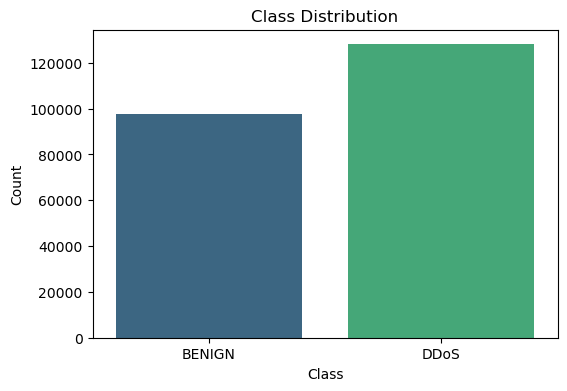

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics for numeric columns
df.describe().T.head(10)  # first 10 features just to preview

# Class balance visualization
plt.figure(figsize=(6,4))
sns.countplot(x="Label", data=df, palette="viridis")
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()


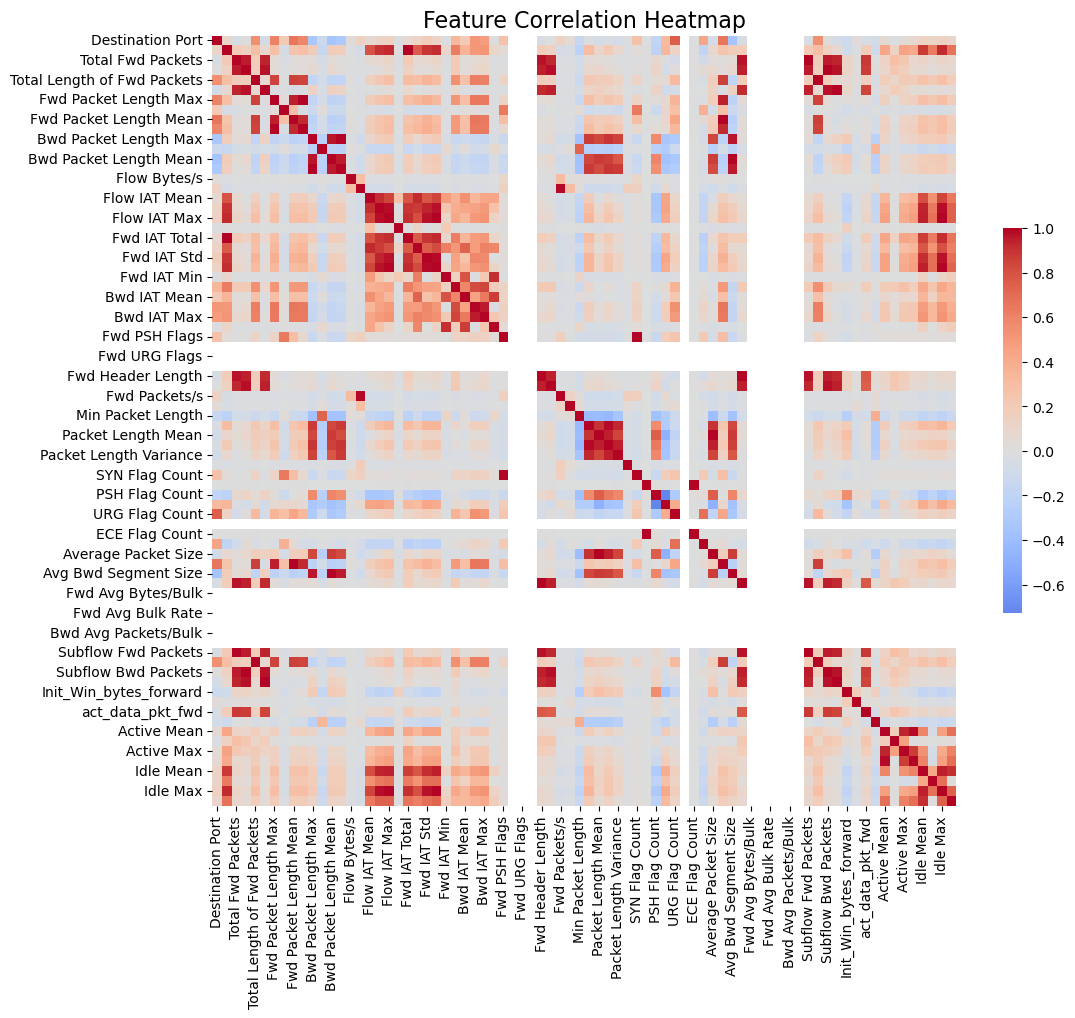

In [11]:
# Compute correlation matrix (numeric features only)
corr = df.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, cmap="coolwarm", center=0, cbar_kws={'shrink': 0.5})
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()


This heatmap shows the correlation between all numeric features in our dataset.
The color scale runs from blue (negative correlation) to red (positive correlation).

We see several strong red blocks along the diagonal, which are expected because some features are mathematically related — for example:

Fwd Packet Length Max / Mean / Std

Bwd Packet Length Max / Mean / Std

Flow IAT Mean / Std / Max / Min

High correlation means these features carry very similar information. Later in preprocessing, we can drop some of these to reduce redundancy and avoid overfitting.

This step is important because it helps simplify the model, improve training speed, and potentially improve generalization.



/var/folders/v2/c51bqtts6yv14k61ylzc2htr0000gn/T/ipykernel_68604/12124293.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Label", y=feature, data=df, palette="Set2")
/var/folders/v2/c51bqtts6yv14k61ylzc2htr0000gn/T/ipykernel_68604/12124293.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Label", y=feature, data=df, palette="Set2")
/var/folders/v2/c51bqtts6yv14k61ylzc2htr0000gn/T/ipykernel_68604/12124293.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Label", y=feature, data=df, palette="Set2")
/var/folders/v2/c51bqtts6

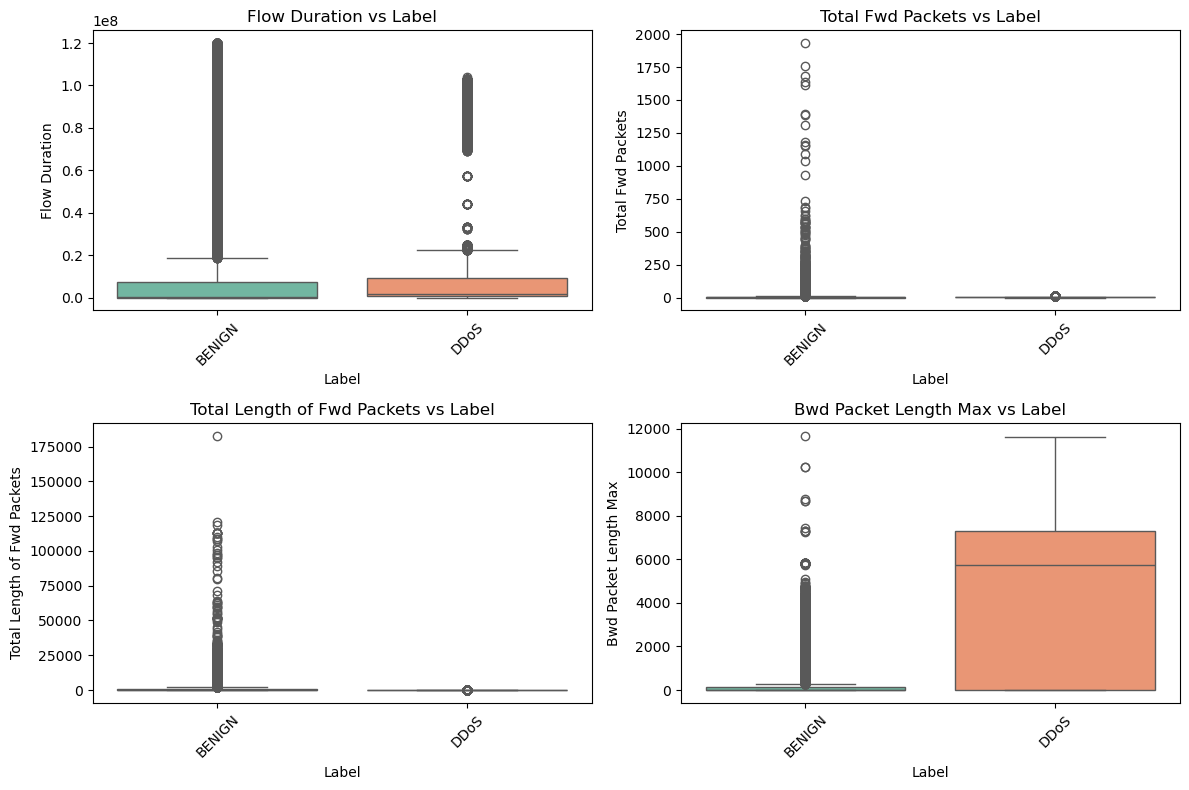

In [12]:
# Pick 4 features to visualize against the Label
features_to_plot = [
    "Flow Duration",
    "Total Fwd Packets",
    "Total Length of Fwd Packets",
    "Bwd Packet Length Max"
]

plt.figure(figsize=(12,8))

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x="Label", y=feature, data=df, palette="Set2")
    plt.title(f"{feature} vs Label")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


Here we are visualizing how selected numerical features differ between BENIGN and DDoS traffic.
Each boxplot shows the median, spread, and outliers for one feature, split by class.

Two features in particular stand out:

Bwd Packet Length Max: DDoS flows tend to have much higher values compared to BENIGN.

Total Fwd Packets: BENIGN traffic shows higher variation, while DDoS traffic is often low and consistent.

These visual differences suggest that such features can be strong indicators for classifying network traffic and will likely carry high importance in our model.

In [13]:
## Outlier Detection & Removal Strategy (IQR method)

# Select numeric columns only
numeric_cols = df.select_dtypes(include=[np.number]).columns

outlier_counts = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
    outlier_counts[col] = outliers

# Sort by most outliers
outlier_counts = dict(sorted(outlier_counts.items(), key=lambda x: x[1], reverse=True))

# Show top 10 features with most outliers
outlier_counts_top10 = {k: v for k, v in list(outlier_counts.items())[:10]}
outlier_counts_top10


{'Destination Port': np.int64(88794),
 'Flow Bytes/s': np.int64(46421),
 'Active Mean': np.int64(43738),
 'Active Max': np.int64(43738),
 'Active Min': np.int64(43648),
 'Bwd Packets/s': np.int64(40923),
 'Fwd Packets/s': np.int64(39806),
 'Flow Packets/s': np.int64(39149),
 'Total Length of Fwd Packets': np.int64(37478),
 'Subflow Fwd Bytes': np.int64(37478)}

We used the Interquartile Range (IQR) method to detect extreme outliers in each numeric feature.
An outlier here is a value that lies far outside the typical range of that feature’s values.

The feature with the most outliers is Destination Port, with about 88k instances outside the normal range. Other features like Flow Bytes/s and Active Mean/Max also have many outliers.

Outlier detection is important because some algorithms, especially distance-based ones like KNN, can be sensitive to extreme values. We’ll later decide whether to remove or transform these values, or to let the model handle them if using tree-based methods.

In [15]:
# Some numeric columns contain ∞ (infinity) values (common in CICIDS for rates like Flow Bytes/s due to division by zero). VarianceThreshold can’t handle inf, so we need to clean them.

import numpy as np
import pandas as pd

# 1) Count infinities per numeric column
numeric_df = df.select_dtypes(include=[np.number])
inf_counts = np.isinf(numeric_df).sum()
print("Columns with inf values:")
print(inf_counts[inf_counts > 0].sort_values(ascending=False))

# 2) Replace +/-inf with NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3) Impute remaining NaNs in numeric columns with median (safe + robust)
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

# Quick sanity check
print("\nAny NaNs left in numeric columns?", df[numeric_cols].isna().sum().sum())


Columns with inf values:
Flow Packets/s    34
Flow Bytes/s      30
dtype: int64

Any NaNs left in numeric columns? 0


In [16]:
from sklearn.feature_selection import VarianceThreshold

# 1. Drop obvious ID-like columns if present
id_like_cols = [c for c in df.columns if "ID" in c or "IP" in c]
print("Dropping ID-like columns:", id_like_cols)
df = df.drop(columns=id_like_cols, errors='ignore')

# 2. Remove zero-variance features
selector = VarianceThreshold(threshold=0.0)
selector.fit(df.select_dtypes(include=[np.number]))
zero_var_cols = df.select_dtypes(include=[np.number]).columns[~selector.get_support()]
print("Zero-variance columns:", list(zero_var_cols))
df = df.drop(columns=zero_var_cols, errors='ignore')

# 3. Remove highly correlated features
corr_matrix = df.corr(numeric_only=True).abs()
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

high_corr_cols = [
    column for column in upper_triangle.columns if any(upper_triangle[column] > 0.95)
]
print("Highly correlated columns to drop:", high_corr_cols)
df = df.drop(columns=high_corr_cols, errors='ignore')

print("Final shape after feature selection:", df.shape)


Dropping ID-like columns: []
Zero-variance columns: ['Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'CWE Flag Count', 'Fwd Avg Bytes/Bulk', 'Fwd Avg Packets/Bulk', 'Fwd Avg Bulk Rate', 'Bwd Avg Bytes/Bulk', 'Bwd Avg Packets/Bulk', 'Bwd Avg Bulk Rate']
Highly correlated columns to drop: ['Total Backward Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Std', 'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow IAT Max', 'Fwd IAT Total', 'Fwd IAT Std', 'Fwd IAT Max', 'Bwd IAT Max', 'Fwd Header Length', 'Bwd Header Length', 'Fwd Packets/s', 'Packet Length Std', 'SYN Flag Count', 'ECE Flag Count', 'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size', 'Fwd Header Length.1', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'Active Min', 'Idle Max']
Final shape after feature selection: (225745, 43)


In this step, we reduced the dataset to focus on the most informative features for model training.

1. We first checked for ID-like columns such as Flow IDs or IP addresses, but none were present.

2. We removed 10 zero-variance columns — these had the same value for all rows and add no predictive power.

3. We removed 26 highly correlated features (correlation > 0.95) to avoid redundancy, improve model efficiency, and reduce overfitting risk.

After this process, we went from 79 to 43 features, keeping only the most relevant ones for detecting DDoS vs BENIGN traffic.

In [17]:
from sklearn.model_selection import train_test_split

# Define X and y
X = df.drop(columns=["Label"])
y = df["Label"]

# Stratified split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Label distribution in Train:\n", y_train.value_counts(normalize=True))
print("\nLabel distribution in Test:\n", y_test.value_counts(normalize=True))


Train shape: (180596, 42) Test shape: (45149, 42)
Label distribution in Train:
 Label
DDoS      0.567133
BENIGN    0.432867
Name: proportion, dtype: float64

Label distribution in Test:
 Label
DDoS      0.567122
BENIGN    0.432878
Name: proportion, dtype: float64


We split the cleaned dataset into training and testing sets using an 80/20 split.
The split was stratified, meaning the class distribution in both sets matches the original dataset — about 56.7% DDoS and 43.3% BENIGN.

This ensures our model sees both classes in the same proportions during training and evaluation, helping it generalize better.

In [18]:
import os
from pathlib import Path

PROCESSED_DIR = Path("../data/processed")
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Merge X and y back so each split is self-contained
train_df = X_train.copy()
train_df["Label"] = y_train.values

test_df = X_test.copy()
test_df["Label"] = y_test.values

# Save CSVs
train_path = PROCESSED_DIR / "train.csv"
test_path  = PROCESSED_DIR / "test.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved:")
print(" -", train_path, train_df.shape)
print(" -", test_path,  test_df.shape)

# Also save the final feature list we’ll use in training
import json
features = list(X_train.columns)
with open(PROCESSED_DIR / "features.json", "w") as f:
    json.dump({"features": features, "target": "Label"}, f, indent=2)
print(" -", PROCESSED_DIR / "features.json")


Saved:
 - ../data/processed/train.csv (180596, 43)
 - ../data/processed/test.csv (45149, 43)
 - ../data/processed/features.json
